In [6]:
!pip install fake_useragent
!pip install requests
!pip install bs4
!pip install pyopenssl ndg-httpsclient pyasn1

In [ ]:
import requests
import fake_useragent
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from os import name
from collections import Counter

#Для обработки естественного языка
import re
import string
import nltk
from pymystem3 import Mystem
from nltk.corpus import stopwords
from string import punctuation
from nltk import word_tokenize
from nltk.probability import FreqDist

In [ ]:
number_of_pages = 100

job_title = ["Журналист"]
for job in job_title:
	data=[]
	for i in range(number_of_pages):
	    url = 'https://api.hh.ru/vacancies'
	    par = {'text': job, 'area':'113','per_page':'10', 'page':i}
	    r = requests.get(url, params=par)
	    e=r.json()
	    data.append(e)
	    vacancy_details = data[0]['items'][0].keys()
	    df = pd.DataFrame(columns= list(vacancy_details))
	    ind = 0
	    for i in range(len(data)):
	    	for j in range(len(data[i]['items'])):
	    		df.loc[ind] = data[i]['items'][j]
	    		ind+=1
	df.to_csv("Journalist.csv")

In [ ]:
df['og_link'] = df['alternate_url'] + '?from=vacancy_search_list&hhtmFrom=vacancy_search_list'

In [ ]:
vac_url = df['og_link'].tolist()

In [43]:
def get_vacansy(link):
    ua = fake_useragent.UserAgent()
    data = requests.get(
        url=link,
        headers={"user-agent":ua.random}
    )
    if data.status_code != 200:
        return
    soup = BeautifulSoup(data.content, "lxml")
    try:
        name = soup.find(attrs={"class":"vacancy-title"}).find("h1").text
    except:
        name = ""
    try:
        tags = [tag.text for tag in soup.find(attrs={"class":"bloko-tag-list"}).find_all("span",attrs={"class":"bloko-tag__section_text"})]
    except:
        tags = []
    resume = {
        "name":name,
        "tags":tags,
    }
    return resume

In [55]:
if __name__ == "__main__":
    dat1 = []
    for a in vac_url:
        dat1.append(get_vacansy(a))
        time.sleep(1)
        with open("data.json","w",encoding="utf-8")as f:
            json.dump(dat1,f,indent = 4, ensure_ascii=False)

In [56]:
df_vac = pd.json_normalize(dat1)

In [206]:
df_vac.to_csv('vacancy_data_VKR.csv')

In [151]:
vac_vac = df_vac.copy()

In [154]:
vac_vac.tags = vac_vac.tags.apply(lambda x: np.nan if len(x)==0 else x)

In [155]:
vac_vac.dropna()

,name,tags
1,Журналист-копирайтер,"[Грамотная речь, Грамотность, Написание тексто..."
2,Журналист-копирайтер,"[Написание текстов, Грамотность, Adobe Photosh..."
3,Журналист,"[Заключение договоров, Ведение переговоров, За..."
4,Журналист/SMM-менеджер,"[Пользователь ПК, Грамотная речь, Грамотность,..."
5,Журналист-копирайтер,"[Написание текстов, Написание статей, Грамотно..."
...,...,...
567,Начальник пресс-службы,"[Копирайтинг, Креативность, Написание текстов,..."
569,"Директор по маркетингу и PR (IT, CMO)","[Стрессоустойчивость, PR, Анализ PR стратегии ..."
572,"Маркетолог (реклама, SMM, PR)","[Копирайтинг, Написание текстов, Грамотность, ..."
573,"Менеджер по маркетингу, рекламе и PR (Москва)","[PR, Продвижение бренда, Маркетинговые коммуни..."


In [80]:
name_list = df_vac['name'].tolist()

In [89]:
texx = ' '.join(name_list)
texx = texx.replace('-', ' ')
texx = texx.replace('/', ' ')
texx

'Корреспондент (Журналист) Журналист копирайтер Журналист копирайтер Журналист Журналист SMM менеджер Журналист копирайтер Журналист Копирайтер журналист Журналист копирайтер Журналист Журналист корреспондент Журналист копирайтер Редактор сайта Журналист Amic.ru Журналист Журналист редактор Главный редактор Журналист   фотокорреспондент PR менеджер PR специалист (автор статей журналист) Журналист копирайтер Журналист редактор Редактор звездных новостей Копирайтер PR менеджер Журналист Корреспондент Журналист Корреспондент   редактор "Федеральный бизнес журнал Сибирь" Журналист в недвижимости Журналист (лента спортивных новостей) Журналист корреспондент Журналист копирайтер Журналист (собственный корреспондент) Журналист (менеджер телеграм канала) Журналист редактор новостной ленты Журналист Экономический журналист Журналист Журналист 74.RU Корреспондент редактор PR менеджер Журналист Журналист (общественно политическая тематика) Редактор ленты новостей Журналист Журналист "Наука в Сиби

In [119]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian") + ['это', 'язык', 'умение', 'специалист', 'менеджер','отдел', 'навык', 'хотеть', 'делать', 'начинать', 'хотеться', 'мочь', 'который', 'весь', 'свой']
def preprocess_text(text):
    text = re.sub(r"\n", '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation\
              and token not in russian_stopwords]
    
    text = " ".join(tokens)
    
    return text

In [120]:
texx = preprocess_text(texx)

In [122]:
texx_tokens = word_tokenize(texx)

In [123]:
text1 = nltk.Text(texx_tokens)

In [124]:
fdist = FreqDist(text1)

In [125]:
fdist.most_common(20)

[('журналист', 151),
 ('pr', 137),
 ('редактор', 57),
 ('копирайтер', 44),
 ('корреспондент', 41),
 ('руководитель', 32),
 ('пресс', 29),
 ('сценарист', 26),
 ('автор', 24),
 ('реклама', 22),
 ('контент', 21),
 ('связь', 20),
 ('общественность', 20),
 ('маркетинг', 19),
 ('секретарь', 18),
 ('коммуникация', 18),
 ('manager', 17),
 ('гид', 16),
 ('экскурсовод', 16),
 ('писатель', 16)]

In [126]:
vac_names = pd.DataFrame.from_dict(fdist, orient='index').reset_index()
vac_names = vac_names.rename(columns={'index':'name', 0:'count'})

In [127]:
vac_names['%'] = vac_names['count'].apply(lambda x: x / 577 * 100)
vac_names = vac_names.sort_values('count', ascending=False)
vac_names.index = range(1, len(vac_names)+1)

In [128]:
vac_names[vac_names['%']>3]

,name,count,%
1,журналист,151,26.169844
2,pr,137,23.743501
3,редактор,57,9.878683
4,копирайтер,44,7.625650
5,корреспондент,41,7.105719
6,руководитель,32,5.545927
7,пресс,29,5.025997
8,сценарист,26,4.506066
9,автор,24,4.159445
10,реклама,22,3.812825


In [204]:
vac_names.to_excel('vac_names.xlsx')

In [129]:
list_tags = df_vac['tags'].tolist()

In [134]:
flat_list1 = [item for sublist in list_tags for item in sublist]

['Грамотная речь',
 'Грамотность',
 'Написание текстов',
 'Пользователь ПК',
 'Работа в команде',
 'Английский язык',
 'Написание статей',
 'Работа с большим объемом информации',
 'Креативность',
 'Копирайтинг',
 'Поиск информации в интернет',
 'Организаторские навыки',
 'MS PowerPoint',
 'Internet',
 'Рерайтинг',
 'Высокая скорость печати',
 'Написание текстов',
 'Грамотность',
 'Adobe Photoshop',
 'Рерайтинг',
 'Написание статей',
 'Заключение договоров',
 'Ведение переговоров',
 'Закупка товаров и услуг',
 'Работа в команде',
 'Деловое общение',
 'Экономический анализ',
 'Аналитическое мышление',
 'Деловая коммуникация',
 'Ориентация на результат',
 'Анализ ассортиментной линейки',
 'ABC-анализ',
 'Конкурентная аналитика',
 'Эффективность',
 'Пользователь ПК',
 'Грамотная речь',
 'Грамотность',
 'Поиск информации в интернет',
 'Наполнение контентом',
 'Социальные сети',
 'Написание текстов',
 'Написание статей',
 'Грамотность',
 'Копирайтинг',
 'Грамотная речь',
 'Пользователь ПК',


In [136]:
counts2 = Counter(flat_list1)
print(counts2)

Counter({'Написание текстов': 233, 'Грамотность': 201, 'Грамотная речь': 195, 'Копирайтинг': 104, 'Написание статей': 103, 'PR': 98, 'Креативность': 97, 'Работа в команде': 67, 'Поиск информации в интернет': 64, 'Журналистика': 64, 'Наличие контактов с журналистами': 57, 'Пользователь ПК': 56, 'Английский язык': 53, 'Написание пресс-релизов': 46, 'Работа со СМИ': 44, 'Анализ PR стратегии конкурентов': 40, 'Работа с большим объемом информации': 37, 'Организаторские навыки': 37, 'Организация мероприятий': 35, 'Организация пресс-конференций': 32, 'Управление проектами': 31, 'Наполнение контентом': 30, 'Формирование пула лояльных СМИ': 30, 'Редактирование текстов': 30, 'Творческое мышление': 29, 'Adobe Photoshop': 27, 'Деловая коммуникация': 27, 'Социальные сети': 27, 'SMM': 27, 'Написание сценариев': 27, 'Рерайтинг': 25, 'Редактирование': 25, 'Продвижение бренда': 25, 'PR первых лиц компании': 23, 'Английский\xa0— C1 — Продвинутый': 23, 'SEO': 23, 'Медиа-мониторинг': 22, 'Написание реклам

In [137]:
vac_tags = pd.DataFrame.from_dict(counts2, orient='index').reset_index()
vac_tags = vac_tags.rename(columns={'index':'tag', 0:'count'})

In [138]:
vac_tags['%'] = vac_tags['count'].apply(lambda x: x / 577 * 100)
vac_tags = vac_tags.sort_values('count', ascending=False)
vac_tags.index = range(1, len(vac_tags)+1)

In [161]:
vac_tags['% full'] = vac_tags['count'].apply(lambda x: x / 498 * 100)

In [164]:
new_vac = vac_tags[vac_tags['% full']>3]

In [166]:
new_vac

,tag,count,%,% full
1,Написание текстов,233,40.381282,46.787149
2,Грамотность,201,34.835355,40.361446
3,Грамотная речь,195,33.795494,39.156627
4,Копирайтинг,104,18.024263,20.883534
5,Написание статей,103,17.850953,20.682731
6,PR,98,16.984402,19.678715
7,Креативность,97,16.811092,19.477912
8,Работа в команде,67,11.611785,13.453815
9,Поиск информации в интернет,64,11.091854,12.851406
10,Журналистика,64,11.091854,12.851406


In [165]:
new_vac.to_excel('new_vac.xlsx')

In [205]:
exp_vac_tags = vac_tags[vac_tags['% full']>3.5]

,tag,count,%,expertise,% full
1,Написание текстов,233,40.381282,TE,46.787149
2,Грамотность,201,34.835355,TE,40.361446
3,Грамотная речь,195,33.795494,TE,39.156627
4,Написание статей,103,17.850953,TE,20.682731
5,Журналистика,64,11.091854,TE,12.851406
6,Написание пресс-релизов,46,7.972270,TE,9.236948
7,Работа со СМИ,44,7.625650,TE,8.835341
8,Редактирование текстов,30,5.199307,TE,6.024096
9,Наполнение контентом,30,5.199307,TE,6.024096
10,Редактирование,25,4.332756,TE,5.020080


In [142]:
exp_vac_tags['expertise'] = ""

/var/folders/60/_z075k0x7vj3knd271vbfbf80000gn/T/ipykernel_45020/1465234115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_vac_tags['expertise'] = ""


In [144]:
exp_vac_tags.loc[1,'expertise'] = 'TE'
exp_vac_tags.loc[2,'expertise'] = 'TE'
exp_vac_tags.loc[3,'expertise'] = 'TE'
exp_vac_tags.loc[4,'expertise'] = 'IntE'
exp_vac_tags.loc[5,'expertise'] = 'TE'
exp_vac_tags.loc[6,'expertise'] = 'IntE'
exp_vac_tags.loc[7,'expertise'] = 'AE'
exp_vac_tags.loc[8,'expertise'] = 'IntE'
exp_vac_tags.loc[9,'expertise'] = 'InnE'
exp_vac_tags.loc[10,'expertise'] = 'TE'
exp_vac_tags.loc[11,'expertise'] = 'IntE'
exp_vac_tags.loc[12,'expertise'] = 'InnE'
exp_vac_tags.loc[13,'expertise'] = 'AE'
exp_vac_tags.loc[14,'expertise'] = 'TE'
exp_vac_tags.loc[15,'expertise'] = 'TE'
exp_vac_tags.loc[16,'expertise'] = 'IntE'
exp_vac_tags.loc[17,'expertise'] = 'InnE'
exp_vac_tags.loc[18,'expertise'] = 'AE'
exp_vac_tags.loc[19,'expertise'] = 'AE'
exp_vac_tags.loc[20,'expertise'] = 'AE'
exp_vac_tags.loc[21,'expertise'] = 'AE'
exp_vac_tags.loc[22,'expertise'] = 'TE'
exp_vac_tags.loc[23,'expertise'] = 'TE'
exp_vac_tags.loc[24,'expertise'] = 'AE'
exp_vac_tags.loc[25,'expertise'] = 'AE'
exp_vac_tags.loc[26,'expertise'] = 'IntE'
exp_vac_tags.loc[27,'expertise'] = 'InnE'
exp_vac_tags.loc[28,'expertise'] = 'InnE'
exp_vac_tags.loc[29,'expertise'] = 'InnE'
exp_vac_tags.loc[30,'expertise'] = 'InnE'
exp_vac_tags.loc[31,'expertise'] = 'IntE'
exp_vac_tags.loc[32,'expertise'] = 'TE'
exp_vac_tags.loc[33,'expertise'] = 'TE'
exp_vac_tags.loc[34,'expertise'] = 'IntE'
exp_vac_tags.loc[35,'expertise'] = 'AE'
exp_vac_tags.loc[36,'expertise'] = 'IntE'
exp_vac_tags.loc[37,'expertise'] = 'InnE'
exp_vac_tags.loc[38,'expertise'] = 'IntE'
exp_vac_tags.loc[39,'expertise'] = 'InnE'
exp_vac_tags.loc[40,'expertise'] = 'TE'
exp_vac_tags.loc[41,'expertise'] = 'IntE'
exp_vac_tags.loc[42,'expertise'] = 'IntE'

/Users/alla/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [175]:
exp_vac_stat = exp_vac_tags.groupby(['expertise']).sum()
exp_vac_stat.to_excel('exp_vac_stat.xlsx')

In [183]:
exp_vac_stat['exp'] = exp_vac_stat.index

In [186]:
exp_vac_stat['count %'] = exp_vac_stat['count'].apply(lambda x: x / 2211 * 100)

In [190]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

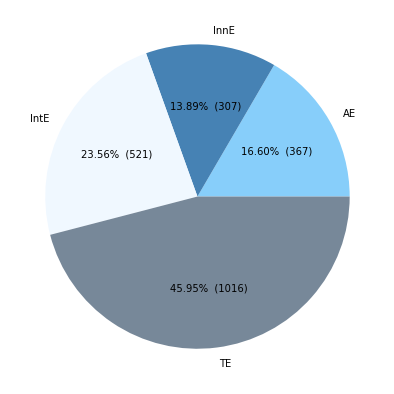

In [197]:
fig = plt.figure(figsize =(10, 7))
plt.pie(exp_vac_stat['count'], labels = exp_vac_stat['exp'], autopct=make_autopct(exp_vac_stat['count']), colors = ['lightskyblue', 'steelblue', 'aliceblue', 'lightslategray'])
plt.savefig('exp_vac_stat.png')

In [174]:
exp_vac_stat['count'].sum()

2211

In [172]:
exp_vac_tags.groupby(['expertise']).count()

,tag,count,%,% full
expertise,,,,
AE,9,9,9,9
InnE,9,9,9,9
IntE,12,12,12,12
TE,12,12,12,12


In [159]:
exp_vac_tags = exp_vac_tags.sort_values(['expertise', 'count'], ascending=[False, False])
exp_vac_tags.index = range(1, len(exp_vac_tags)+1)

,tag,count,%,expertise,% full
1,Написание текстов,233,40.381282,TE,46.787149
2,Грамотность,201,34.835355,TE,40.361446
3,Грамотная речь,195,33.795494,TE,39.156627
4,Написание статей,103,17.850953,TE,20.682731
5,Журналистика,64,11.091854,TE,12.851406
6,Написание пресс-релизов,46,7.972270,TE,9.236948
7,Работа со СМИ,44,7.625650,TE,8.835341
8,Редактирование текстов,30,5.199307,TE,6.024096
9,Наполнение контентом,30,5.199307,TE,6.024096
10,Редактирование,25,4.332756,TE,5.020080


In [160]:
exp_vac_tags.to_excel('exp_vac_tags.xlsx')

In [147]:
vals = exp_vac_tags['expertise'].tolist()
colors = ["pink" if i == 'TE' else "lavenderblush" if i == 'InnE' else 'palevioletred' if i == 'IntE' else 'crimson' for i in vals]

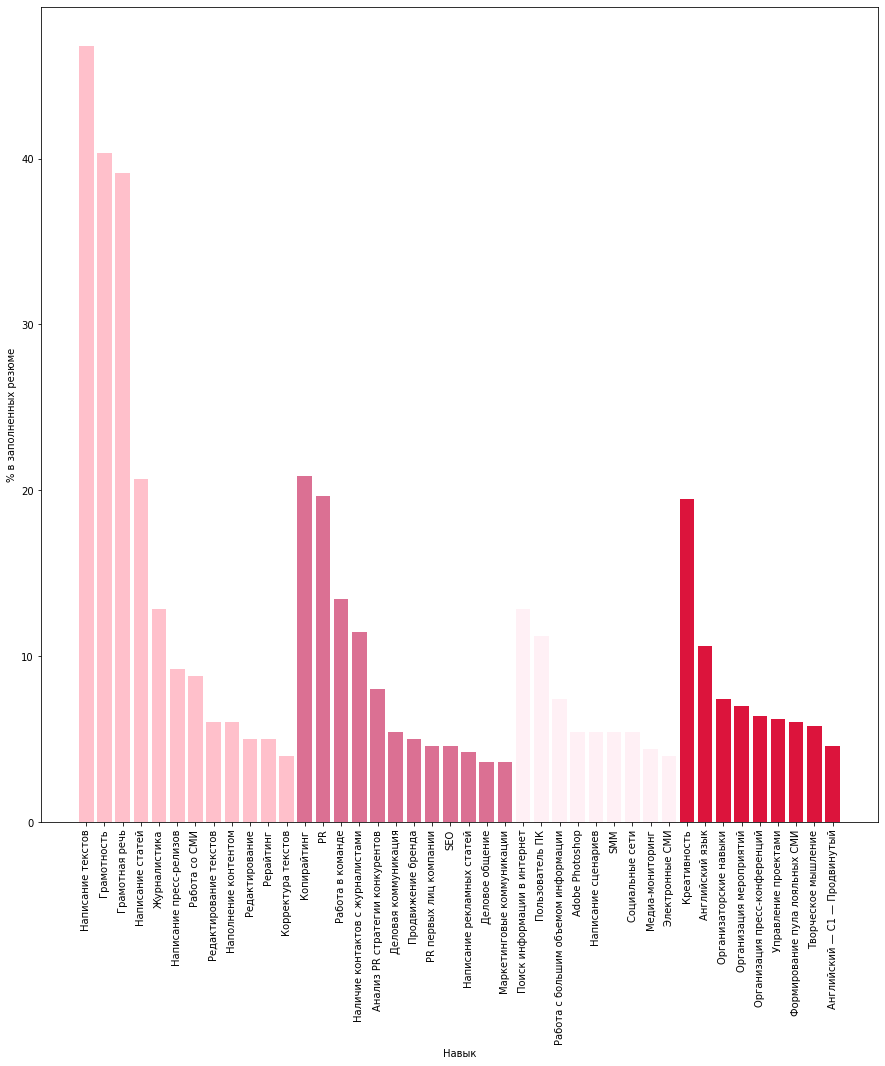

In [203]:
plt.figure(figsize=(15,15))
plt.bar(exp_vac_tags['tag'], exp_vac_tags['% full'], color = colors)
plt.ylabel(f'% в заполненных резюме')
plt.xlabel('Навык')
plt.xticks(rotation=90)
plt.savefig('exp_vac_tags.png')